Import Packages

In [14]:
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()
from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt

Loading the data

In [2]:
data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "2000-01-03", end = "2020-03-10", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 downloaded


In [3]:
dataframe = data.copy()
dataframe['spx'] = dataframe['^GSPC'].Close[:]
dataframe['dax'] = dataframe['^GDAXI'].Close[:]
dataframe['ftse'] = dataframe['^FTSE'].Close[:]
dataframe['nikkei'] = dataframe['^N225'].Close[:]

In [4]:
dataframe = dataframe.iloc[1:]
del dataframe['^N225']
del dataframe['^GSPC']
del dataframe['^GDAXI']
del dataframe['^FTSE']
dataframe = dataframe.asfreq('b')
dataframe = dataframe.fillna(method='ffill')

In [5]:
dataframe['ret_spx'] = dataframe.spx.pct_change(1)*100
dataframe['ret_ftse'] = dataframe.ftse.pct_change(1)*100
dataframe['ret_dax'] = dataframe.dax.pct_change(1)*100
dataframe['ret_nikkei'] = dataframe.nikkei.pct_change(1)*100

In [6]:
size = int(len(dataframe)*0.8)
df_train, df_test = dataframe.iloc[:size], dataframe.iloc[size:]

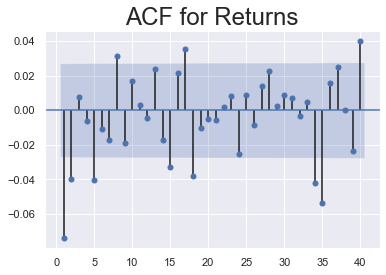

In [15]:
sgt.plot_acf(dataframe.ret_spx[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size=24)
plt.show()

Auto ARIMA

In [7]:
model_auto = auto_arima(dataframe.ret_spx[1:], exogenous = dataframe[['ret_ftse', 'ret_dax', 'ret_nikkei']][1:],
                    m = 5,max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                    maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                    out_of_sample = int(len(dataframe)*0.2))


#exogenous:outside factors (e.g other time series)
#m:seasonal cycle length
#max_order:maximum amount of variables to be used in the regression (p + q)
#max_p:maximum AR components
#max_q:maximum MA components
#max_d:maximum Integrations
#maxiter:maximum iterations we're giving the model to converge the coefficients
#alpha:level of significance, default is 5%, which we should be using most of the time
#n_jobs:how many models to fit at a time (-1 indicates "as many as possible")
#oob:out of bag(for validation scoring)
#out_of_smaple:validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

In [8]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5265
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 5)   Log Likelihood               -6895.547
Date:                             Wed, 11 Mar 2020   AIC                          13815.095
Time:                                     19:55:37   BIC                          13893.921
Sample:                                 01-05-2000   HQIC                         13842.650
                                      - 03-10-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0180      0.017     -1.083      0.279      -0.050       0.015
drift       1.648e-06      2e-06      0.823      0.411   -2.28e-06    5.57e-06
ret_ftse       0.1656      0.011     14.420      0.000       0.143       0.188
ret_dax        0.3880      0.009     44.166      0.000       0.371       0.405
ret_nikkei    -0.0307      0.006     -4.960      0.000      -0.043      -0.019
ar.L1          0.7439      0.307      2.422      0.015       0.142       1.346
ar.L2         -0.0149      0.044     -0.342      0.732      -0.100       0.070
ma.L1         -1.0683      0.307     -3.479      0.001      -1.670      -0.467
ma.L2          0.2375      0.136      1.751      0.080      -0.028       0.503
ar.S.L5       -0.0048      0.398     -0.012      0.990      -0.786       0.776
ma.S.L5       -0.0181      0.398     -0.046      0.964      -0.798       0.762
sigma2         0.7947      0.008     97.570      0.000       0.779       0.811
===================================================================================
Ljung-Box (Q):                       83.49   Jarque-Bera (JB):             10146.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""